<a href="https://colab.research.google.com/github/bachaudhry/FastAI-22-23/blob/main/course_part_2/01A_Stable_Diffusion_Under_the_Hood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stable Diffusion - A Look Under the Hood**

I'll be attempting to better understand the mechanics of the Hugging Face diffusers library by re-creating [J. Whitaker's excellent run-through](https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb).

In [1]:
# Installing requirements for this NB
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.9 MB/s eta 0:00:00


In [2]:
from base64 import b64encode
from google.colab import userdata
userdata.get('HFtoken')

import numpy as np
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# Setup for Vid display
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Warning suppression when loading CLIPTextModel
logging.set_verbosity_error()

# Choose cuda or cpu, since we won't be requiring mps
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


0it [00:00, ?it/s]

## Load Models

GPU memory is an ever present concern. Let's work with the suggested work arounds in the original notebook i.e.:
1. Switch to `fp16`
2. Experiment with attention slicing
3. Keep VAE on the CPU

In [3]:
# Autoencoder model for decoding latents into the image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4",
                                    subfolder="vae")#, variant="fp16",
                                    #torch_dtype=torch.float16)

# Tokenizer and the text encoder to tokenize and encode the text
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")#,
                                          # variant="fp16")#,
                                          #torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")#.half() # convert to half precision

# UNet model to generate latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4",
                                            subfolder="unet")#, variant="fp16",
                                            #torch_dtype=torch.float16)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012,
                                 beta_schedule="scaled_linear",
                                 num_train_timesteps=1000)

# Loading components onto the GPU and CPU
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

## Running a Diffusion Loop

In [4]:
# Starting off with settings
prompt = ["An oil on canvas painting of a Peace Lily"]
height = 512                      # Default height of Stable Diffusion
width = 512                       # Default width
num_inference_steps = 30          # Number of denoising steps
guidance_scale = 7.5              # Scale for classifier-free guidance
generator = torch.manual_seed(32) # Seed generator for initial latent noise
batch_size = 1

In [5]:
# Prep Text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length,
                       truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)

with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

**Note on Unconditional Inputs and Embeddings**

_Source: ChatGPT_

**Unconditional Input**: The `uncond_input` variable in the first code block represents the unconditional input, which is essentially an empty input. It's created to generate unconditional embeddings, but it doesn't carry any meaningful information itself. Its purpose is to ensure that the model receives some form of input during training or inference, even if it's empty.

**Unconditional Embeddings**:  the `uncond_embeddings` variable contains the embeddings generated from the unconditional input. These embeddings capture additional context or information that complements the specific input text.
This leads to some additional benefits for generative modeling:

1. **Enhanced Representation**: By including unconditional embeddings, the model can capture additional context or information that might be beneficial for the task at hand. These embeddings can provide a broader context or background knowledge that complements the specific input text.

2. **Regularization**: Including unconditional embeddings can act as a form of regularization, helping prevent overfitting by providing additional generalization capabilities to the model. This regularization can help improve the model's ability to generalize to unseen data.

3. **Controlled Generation**: In some cases, unconditional embeddings might be used to control or influence the generation process of the model. By providing additional context through unconditional embeddings, the model can generate more diverse or targeted outputs.

4. **Conditional Generation**: Unconditional embeddings can be useful in conditional generation tasks where the model needs to generate output based on both the input text and some additional context. By incorporating unconditional embeddings along with the input text embeddings, the model can better capture the conditional dependencies between different parts of the input.

Overall, the addition of unconditional embeddings can help improve the performance and robustness of the model by providing additional context or regularization during training and inference.

In [6]:
# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
  scheduler.set_timesteps(num_inference_steps)
  scheduler.timesteps = scheduler.timesteps.to(torch.float32) # Needs Altering due to memory issues.

set_timesteps(scheduler, num_inference_steps)

In [7]:
# Prep latents
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator = generator
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # This version introuces scaling

<ipython-input-7-742c79a3ec6c>:3: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

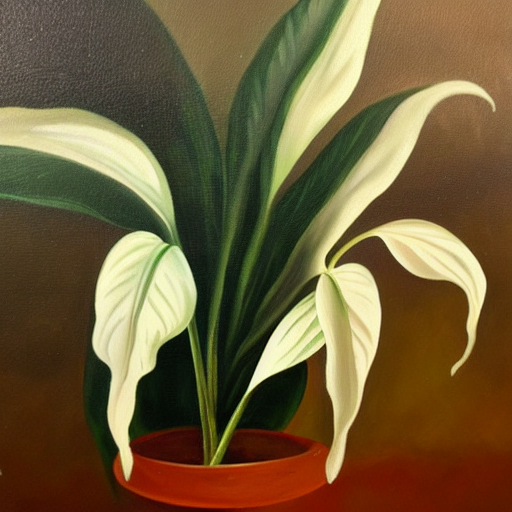

In [8]:
# Inference loop
with autocast("cuda"): # Reverts to CPU if there is no CUDA
  for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # Expand the latents if we are applying classifier free guidance to avoid two forward passes
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    # Scale the latents (pre-conditioning)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

# Scale and decode the image latents with vae
latents = 1 / 0.18215 * latents ## the scaling factor was implemented in the original paper.
with torch.no_grad():
  image = vae.decode(latents).sample

# Display output
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]


## The Autoencoder (AE)

The AE is used to encode an image into some form of latent representation, and then decode this back into an image.

In [9]:
def pil_to_latent(input_im):
  # Single image to single latent in a batch
  with torch.no_grad():
    latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2 - 1)
  # Scaling from before
  return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
  # batch of latents to list of images
  latents = (1 / 0.18215) * latents
  with torch.no_grad():
    image = vae.decode(latents).sample
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy() # For reference permute consists of (bs, h, w, ch)
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

In [10]:
import os
os.chdir('/content/drive/MyDrive/Pic_samples/')
input_image = plt.imread('pasha.jpg')

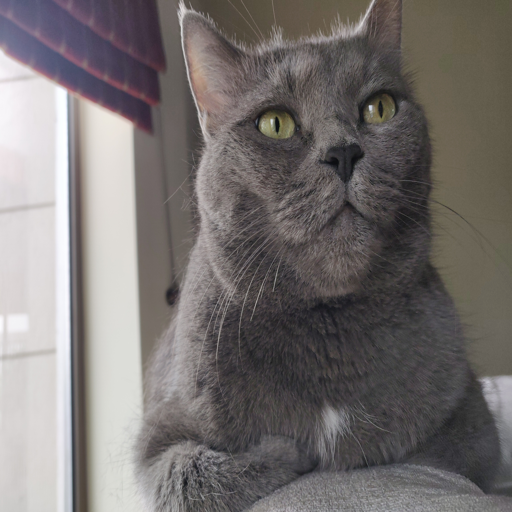

In [11]:
# Load the image
input_image = Image.open('pasha.jpg').resize((512, 512)) # Dimensions have to be a multiple of 8 to avoid errors
input_image

In [12]:
# Encoding to the latent space
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

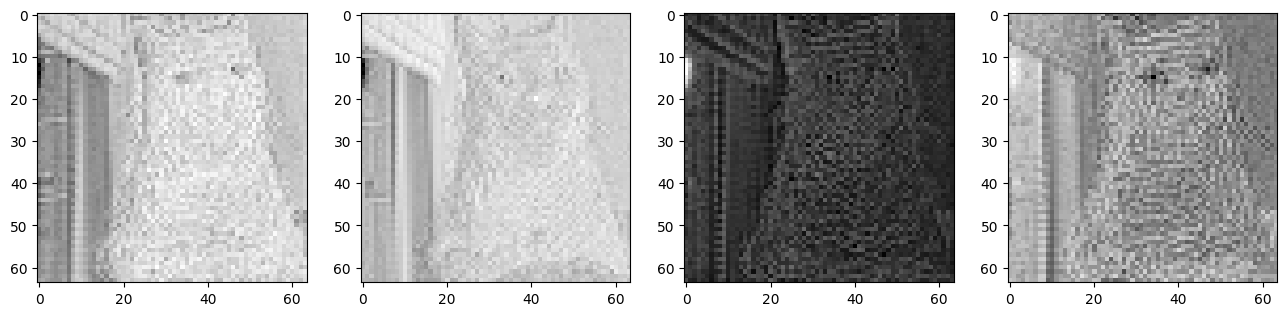

In [13]:
# Visualizing the channels
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
  axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

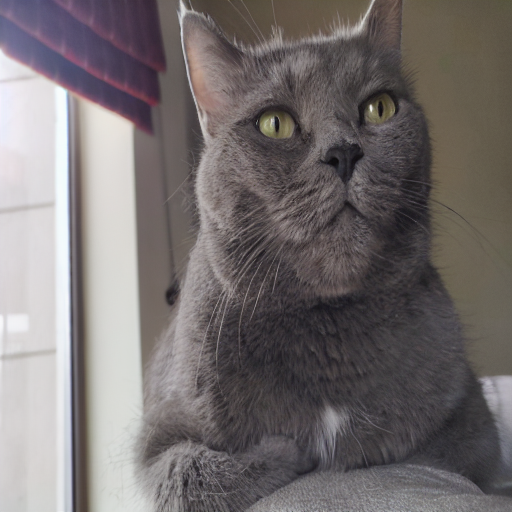

In [14]:
# Decoding the latent representation back to it's original format.
decoded = latents_to_pil(encoded)[0]
decoded

When taking a closer look at the decoded image (being a 4 x 4 x 64 latent), the addition of extra around detail in Pasha's retinas becomes apparent. There is also some additional shading around the whiskers and her chin. This seems to indicate that the latent holds more information than the input.

## The Scheduler

In this section, we will look at the process of adding noise during training and having the model predict the noise. Adding very little noise and, conversely, too much noise hinders the generation process because the model either has very little or too much information to work with.


In [15]:
# Setting number of sampling timesteps which are lower than the one used to train the
# model
set_timesteps(scheduler, 20)
print(scheduler.timesteps)

tensor([999.0000, 946.4211, 893.8421, 841.2632, 788.6842, 736.1053, 683.5263,
        630.9474, 578.3684, 525.7895, 473.2105, 420.6316, 368.0526, 315.4737,
        262.8947, 210.3158, 157.7368, 105.1579,  52.5789,   0.0000])


In [16]:
# These are the equivalent noise levels
print(scheduler.sigmas)

tensor([14.6146, 10.7469,  8.0815,  6.2050,  4.8557,  3.8654,  3.1238,  2.5572,
         2.1157,  1.7648,  1.4806,  1.2458,  1.0481,  0.8784,  0.7297,  0.5964,
         0.4736,  0.3555,  0.2322,  0.0292,  0.0000])


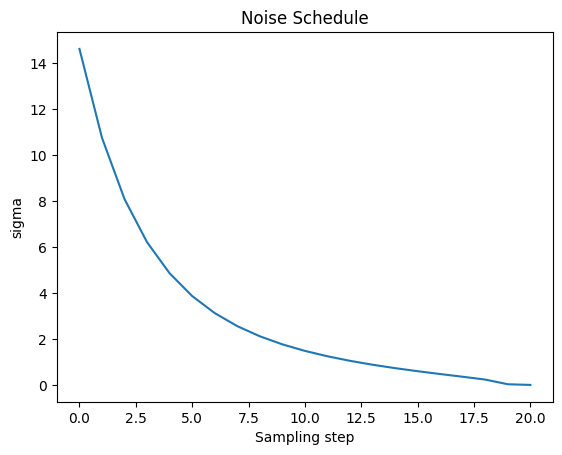

In [17]:
# Plotting the noise schedule
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

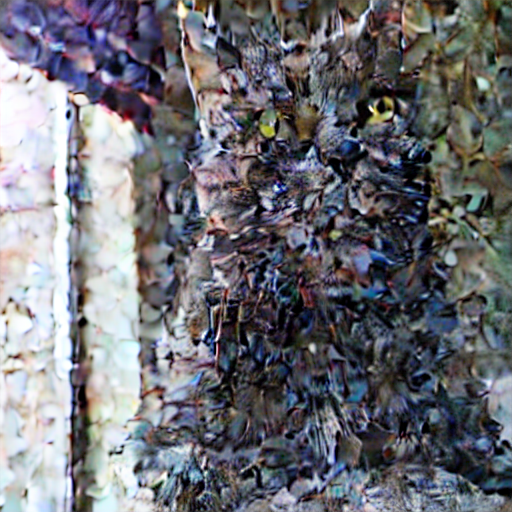

In [18]:
# Adding random noise into our encoded image
noise = torch.randn_like(encoded)
sampling_step = 15
encoded_and_noised = scheduler.add_noise(encoded,
                                          noise,
                                          timesteps=torch.tensor([scheduler.timesteps[sampling_step]]))
# Display noised image
latents_to_pil(encoded_and_noised.float())[0]


In [19]:
?? scheduler

## Loop Starts from Noised Version of Input **(ImagetoImage)**

  0%|          | 0/100 [00:00<?, ?it/s]

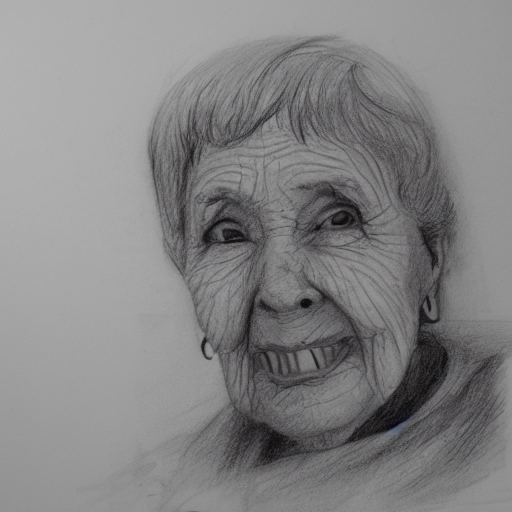

In [25]:
# Same settings as the previous loop except for the prompt
prompt = ["Old woman drinking tea, pencil sketch"]
height = 512
width = 512
num_inference_steps = 100
guidance_scale = 8
generator = torch.manual_seed(32)
batch_size = 1
# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length,
                         truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
# Prep scheduler
set_timesteps(scheduler, num_inference_steps)
# Prep latents
start_step = 10
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
latents = latents.to(torch_device).float()
# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
  if i >= start_step: # Modification to the loop
    # expand latents if we're doing classifire free guidance to avoid 2 forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)
    # Predict noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    # Compute previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

# Output
latents_to_pil(latents)[0]


Addings more noise and more steps will further separate the input image from the generated outputs.